# ASTRON 3350 Final Project
### Project 8: Software Benchmarking
Connor Fricke and Nathan Holty  
Fricke.59@osu.edu and Holty.1@osu.edu  
Last date of Revision: December 7th, 2023

## A sketch of the code benchmarking problem

Here we rough out a few necessary components for spectrum synthesis.

Lots of this will be done in pure python.  A few operations are done
with numpy if they are done only once.  It is the operations that are
done repeatedly that are the best candidates for code improvments.

Even without going all the way to C++, it would be good to replace
some pure python operations with numpy array functions and see how
much that improves things.

In [1]:
# Get packages
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Specify needed items.

# Start, end wavelength for the spectrum and number of points
startw = 900.       # Angstroms
finalw = 2900.
nspect = 2048

# Number of lines in the spectrum model
nlines = 10

# Width of each line in gaussian sigma, in Angstroms
lsigma = 4.0

# Width of halfnormal distribution.  We use a halfnormal distribution
# of line depths so most are near zero and only a few are much larger.
halfsig = 0.1

In [3]:
# Generate a wavelength list for the spectrum.
wavels = np.linspace(startw, finalw, nspect, endpoint=True)

### We need a list of wavelengths and line depths in order to synthesize a spectrum.

In [4]:
# We need a list of wavelengths and line depths in order to synthesize a spectrum.
# Generate list of line depths and fix up so none are > 1.0
# We want the absolute value of a normal distribution

depths = np.absolute(np.random.normal(0.0, halfsig, nlines))
depths[depths > 1.0] = 1.0
print(depths)

# Generate a list of line wavelengths, which we take as
# uniformly distributed over the spectrum
lwaves = np.random.uniform(startw, finalw, nlines)
print(lwaves)


[0.12908742 0.20356893 0.0216305  0.05871624 0.01405919 0.04499715
 0.02541998 0.11035373 0.05326108 0.03200053]
[2207.93009088 2615.14913408 2329.16039806 2621.77707413 2790.89666927
 2139.6295086  2067.9258263  2884.72127534  974.05381118 2023.59244927]


### We start with a blank spectrum, then add on a series of lines.

In [5]:
# We start with a blank spectrum, then add on a series of lines.
# Function to return an I/Io spectrum, meaning a spectrum normalized so
# the continuum is 1 everywhere.
def blankspec(npts):
    """
    Generate a blank spectrum with a given number of points.

    Parameters:
    - npts (int): Number of points in the spectrum.

    Returns:
    - list: A list representing a blank spectrum with each point initialized to 1.0.
    """
    B = [1.0 for n in range(npts)]
    return B

In [6]:
# Gauss function
from numpy import exp
def gauss(w, cent, depth, sigma):
    """
    Generate a Gaussian profile for a spectral line.

    Parameters:
    - w (float): Wavelength values.
    - cent (float): Central wavelength of the Gaussian profile.
    - depth (float): Depth or amplitude of the Gaussian profile.
    - sigma (float): Standard deviation (sigma) of the Gaussian profile.

    Returns:
    - float: The value of the Gaussian profile at the given wavelength.
    """
    gval = -depth * exp(-(w - cent)**2 / 2.0 / sigma**2)
    return gval

In [7]:
# Test with a single line
linecenter = 2023.9
linedepth  = 0.4

blank = blankspec(nspect)
spect = []
for k in range(len(wavels)):
    w = wavels[k]
    d = gauss(w, linecenter, linedepth, lsigma)
    s = blank[k] + d
    spect.append(s)

Text(0, 0.5, 'Spectrum')

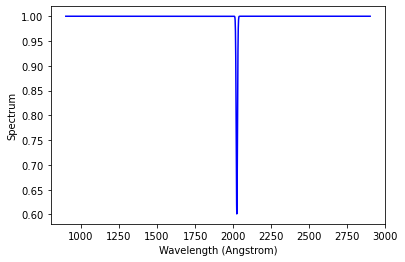

In [8]:
fig, ax = plt.subplots()
ax.plot(wavels, spect, 'blue')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Spectrum')

### How to make a full spectrum.

For each line in the line list:
- Generate a spectrum with a single line. If there are N lines in the list, you get N spectra.
- Multiply all these together.

#### Approach
To do this we can loop over the range in nlines which is the number of lines in each spectrum model. We can then generate a spectrum with a single line by taking the range in the length of the wavelength list. Lastly, we can then multiply them together using the `np.multiply()` function. Below is the code to accomplish this:

To do this we include a loop that iterates over each line in the list. Inside the loop, a spectrum with a single line is generated for each line, and then these spectra are multiplied together to create the final spectrum.

1. We add the following line before the loop to initialize the total_spectrum with all 1.0s using the defined blankspec definition:
```total_spectrum = blankspec(nspect)```
2. Then, replace the existing loop for testing a single line with a new loop that iterates over each line in the list. Inside this loop, we generate a spectrum with a single line labled line_spectrum and then multiply it with the total_spectrum using:
```line_spectrum = np.multiply(total_spectrum, line_spectrum)```
3. Finally, after the loop, we include the necessary code to plot the spectrum if desired.

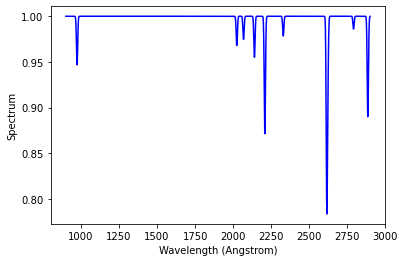

In [9]:
# Initialize the spectrum with all ones
total_spectrum = blankspec(nspect)

# Loop over each line, generate a spectrum with a single line, and multiply them together
for i in range(nlines):
    linecenter = lwaves[i]
    linedepth = depths[i]

    # Generate a spectrum with a single line
    line_spectrum = blankspec(nspect)
    for k in range(len(wavels)):
        w = wavels[k]
        d = gauss(w, linecenter, linedepth, lsigma)
        line_spectrum[k] += d

    # Multiply the spectra
    total_spectrum = np.multiply(total_spectrum, line_spectrum)

# Plot the final spectrum
fig, ax = plt.subplots()
ax.plot(wavels, total_spectrum, 'blue')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Spectrum')

plt.show()

#### Conclusion
This code generates a spectrum with multiple lines by multiplying spectra with a single line for each line in the list. The final spectrum is then plotted.

### Benchmarking
#### Approach
For measuring performance of the spectral synthesis code, we've introduced a new function named `generate_spectrum`. This function contains the parameters: `start`, `end`, `res`, and `n_lines`, which correspond to the previously used variables `startw`, `finalw`, `nspect`, and `nlines`. These parameters signify the starting and ending wavelengths for the spectrum, the number of data points in the spectrum, and the quantity of spectral lines in the model.

The `generate_spectrum` function outputs two critical arrays: `total_spectrum` and `wavels`. The former represents the synthesized spectrum, while the latter holds the corresponding wavelengths. To validate the functionality of this new function, we can conduct a test run with specific inputs 900, 2900, 2048, and 100 for `start`, `end`, `res`, and `n_lines`, respectively. Subsequently, we print the resulting spectrum.

For completeness, we have included the necessary packages and functions defined in earlier cells within the notebook. This decision ensures that the following code block contains all essential components for spectrum generation and evaluation.

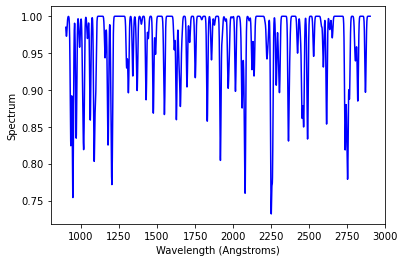

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# We start with a blank spectrum, then add on a series of lines.
# Function to return an I/Io spectrum, meaning a spectrum normalized so
# the continuum is 1 everywhere.
def blankspec(npts):
    """
    Generate a blank spectrum with a given number of points.

    Parameters:
    - npts (int): Number of points in the spectrum.

    Returns:
    - list: A list representing a blank spectrum with each point initialized to 1.0.
    """
    B = [1.0 for n in range(npts)]
    return B

# Gauss function
from numpy import exp
def gauss(w, cent, depth, sigma):
    """
    Generate a Gaussian profile for a spectral line.

    Parameters:
    - w (float): Wavelength values.
    - cent (float): Central wavelength of the Gaussian profile.
    - depth (float): Depth or amplitude of the Gaussian profile.
    - sigma (float): Standard deviation (sigma) of the Gaussian profile.

    Returns:
    - float: The value of the Gaussian profile at the given wavelength.
    """
    gval = -depth * exp(-(w - cent)**2 / 2.0 / sigma**2)
    return gval

# Generate spectrum function 
def generate_spectrum(start, end, res, n_lines):
    """
    Generate a synthetic spectrum with multiple spectral lines.

    Parameters:
    - start (float): Starting wavelength of the spectrum (Angstroms).
    - end (float): Ending wavelength of the spectrum (Angstroms).
    - res (int): Number of points in the spectrum.
    - n_lines (int): Number of spectral lines in the model.

    Returns:
    - tuple: A tuple containing two arrays:
        - total_spectrum (numpy.ndarray): The synthesized spectrum.
        - wavels (numpy.ndarray): Wavelength array corresponding to the spectrum.
    """
    # Rest of your code goes here
    # Start, end wavelength for the spectrum and number of points
    startw = start       # Angstroms
    finalw = end
    nspect = res

    # Number of lines in the spectrum model
    nlines = n_lines

    # Width of each line in gaussian sigma, in Angstroms
    lsigma = 4.0

    # Width of halfnormal distribution.  We use a halfnormal distribution
    # of line depths so most are near zero and only a few are much larger.
    halfsig = 0.1

    # Generate a wavelength list for the spectrum.
    wavels = np.linspace(startw, finalw, nspect, endpoint=True)

    # We need a list of wavelengths and line depths in order to synthesize a spectrum.
    # Generate list of line depths and fix up so none are > 1.0
    # We want the absolute value of a normal distribution

    depths = np.absolute(np.random.normal(0.0, halfsig, nlines))
    depths[depths > 1.0] = 1.0

    # Generate a list of line wavelengths, which we take as
    # uniformly distributed over the spectrum
    lwaves = np.random.uniform(startw, finalw, nlines)

    # Initialize the spectrum with all ones
    total_spectrum = blankspec(nspect)

    # Loop over each line, generate a spectrum with a single line, and multiply them together
    for i in range(nlines):
        linecenter = lwaves[i]
        linedepth = depths[i]

        # Generate a spectrum with a single line
        line_spectrum = blankspec(nspect)
        for k in range(len(wavels)):
            w = wavels[k]
            d = gauss(w, linecenter, linedepth, lsigma)
            line_spectrum[k] += d

        # Multiply the spectra
        total_spectrum = np.multiply(total_spectrum, line_spectrum)
        
    return total_spectrum, wavels

results, wavelengths = generate_spectrum(900, 2900, 2048, 100)

fig, ax = plt.subplots()
ax.plot(wavelengths, results, 'blue')
ax.set_xlabel("Wavelength (Angstroms)")
ax.set_ylabel("Spectrum")

plt.show()

### Benchmarking Continued
#### Approach Continued
Measuring performance benchmarks involves assessing the execution time of your code. In Python, the `timeit` module is commonly used for this purpose. It can be used to measure the time taken for the execution of specific code blocks or functions. 

To use `timeit`, we need to define a new function named `loop_genspec` which contains the function `generate_spectrum` with the input variables. The purpose of the loop_genspec function is to loop over generate_speectrum 10 times so that timeit can measure how long it takes to run generate_speectrum 10 times. This final time is then averaged for all 10 iterations to get an average run time.

Note: The function generate_spectrum could not be directly put into the timeit program because its inital variables could not be included.  i.e. ```total_execution_time = timeit.timeit(generate_spectrum(900, 2900, 2048, 100), number=10)``` Will not work. Instead the following method must be used.

In [11]:
import timeit

# Runs through our algorithm for generating a spectrum 10 times
def loop_genspec():
    spectra = []
    for i in range(11):
        spectrum = generate_spectrum(900, 2900, 2048, 100)
        spectra.append(spectrum)
    return spectra

# Measure the time taken to execute loop_genspec 1 time i.e. generate_spectrum() 10 times
total_execution_time = timeit.timeit(loop_genspec, number=1)

# Calculate the average time per run
average_execution_time = total_execution_time / 10

# Print the average execution time
print(f"Average Execution Time per Run: {average_execution_time:.6f} seconds")

Average Execution Time per Run: 2.062246 seconds


#### Conclusion
The provided code executed the generate_spectrum function 10 times. As a result, it computed and displayed the average execution time per run. Using the initial conditions-900, 2900, 2048, and 100 for startw, finalw, nspect, and nlines, respectively—the calculated average execution time per run was determined to be approximately 2.062246 seconds in Python.

This spectrum synthesis algorithm is replicated in C++ using the same input variables. After running the C++ program 10 times and averaging the run times, an average of 0.0216 seconds was obtained. Comparing the two, the C++ executable is an the order of __100x faster__ than Python over an identical algorithm for the given parameters. It is possible that, given even higher numbers of absorption lines within our spectra, we could see an even further increase in performance of C++ in comparison with Python. The main reason for this significant difference is because C++ is a low-level, extremely powerful compiled language, though syntactically complex. For analysis of big data sets, it is conclusive that using a compiled language like C++ or C can speed up analysis tremendously, even if it takes far longer to write the necessary code. _Please see the main.cpp file included in the project folder for documentation on our C++ algorithm_.